In [1]:
import gymnasium as gym
import numpy as np
import torch
from utils import *
from dreamer import *
import pickle
from collections import namedtuple
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_printoptions(threshold=2000, linewidth=200)
np.set_printoptions(threshold=2000, linewidth=200)

environmentName = "CarRacing-v3"
renderMode = None
numUpdates = 1000
initialNumEpisodes = 5 # How many episodes to play before first update
playInterval = 10   # How often to play an episode to gather new data
stepCountLimit = 256

env = gym.make(environmentName, render_mode=renderMode)
observationShape = torch.tensor(env.observation_space.shape)
actionSize = torch.tensor(env.action_space.shape) if hasattr(env.action_space, 'shape') else np.array([env.action_space.n])
print(f"Env {environmentName} with observations {observationShape} and actions {actionSize}")
dreamer = Dreamer()

EpisodesBuffer = namedtuple('EpisodeBuffer', ['observations', 'actions', 'rewards'])
episodesBuffer = EpisodesBuffer(observations=[], actions=[], rewards=[])

worldModelLosses, reconstructionLosses, priorNetLosses, rewardPredictionLosses = [], [], [], []

totalUpdates = 0
for i in range(-initialNumEpisodes, numUpdates):
    if i % playInterval == 0 or i < 0:
        observation, info = env.reset()
        observations, actions, rewards, dones = [observation], [], [], []
        stepCount, totalReward, done = 1, 0, False
        while not done:
            stepCount += 1
            action = env.action_space.sample()*[1, 5, 0.2] # For now random action, scaled so we go a bit forward
            observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated or stepCount >= stepCountLimit
            totalReward += reward
            
            observations.append(observation)
            actions.append(action)
            rewards.append(reward)
            # dones.append(done)
        # print(f"Total Reward: {totalReward:.4f}"
        
        episodesBuffer.observations.append(torch.from_numpy(np.transpose(np.stack(observations), (0, 3, 1, 2))).to(device).float()/255.0)
        episodesBuffer.actions.append(torch.from_numpy(np.stack(actions)).to(device).float())
        episodesBuffer.rewards.append(torch.tensor(rewards).view(-1, 1).to(device))

    episodeIndex = random.randint(0, len(episodesBuffer.observations) - 1)
    selectedEpisodeObservations = episodesBuffer.observations[episodeIndex]
    selectedEpisodeActions      = episodesBuffer.actions[episodeIndex]
    selectedEpisodeRewards      = episodesBuffer.rewards[episodeIndex]

    worldModelLoss, reconstructionLoss, priorNetLoss, rewardPredictionLoss = dreamer.train(selectedEpisodeObservations, selectedEpisodeActions, selectedEpisodeRewards)
    worldModelLosses.append(worldModelLoss)
    reconstructionLosses.append(reconstructionLoss)
    priorNetLosses.append(priorNetLoss)
    rewardPredictionLosses.append(rewardPredictionLoss)

    if i % 10 == 0 and i >= 0:
        print(f"i = {i:6}, worldModelLoss = {worldModelLoss:.4f}")
env.close()

Env CarRacing-v3 with observations tensor([96, 96,  3]) and actions tensor([3])
i =      0, worldModelLoss = 0.0758
i =     10, worldModelLoss = 0.0501
i =     20, worldModelLoss = 0.0424
i =     30, worldModelLoss = 0.0369
i =     40, worldModelLoss = 0.0527
i =     50, worldModelLoss = 0.0327
i =     60, worldModelLoss = 0.0502
i =     70, worldModelLoss = 0.0328
i =     80, worldModelLoss = 0.0499
i =     90, worldModelLoss = 0.0200
i =    100, worldModelLoss = 0.0326
i =    110, worldModelLoss = 0.0232
i =    120, worldModelLoss = 0.0242
i =    130, worldModelLoss = 0.0268
i =    140, worldModelLoss = 0.0238
i =    150, worldModelLoss = 0.0252
i =    160, worldModelLoss = 0.0461
i =    170, worldModelLoss = 0.0801
i =    180, worldModelLoss = 0.0431
i =    190, worldModelLoss = 0.0312
i =    200, worldModelLoss = 0.0515
i =    210, worldModelLoss = 0.0247
i =    220, worldModelLoss = 0.0347
i =    230, worldModelLoss = 0.0287
i =    240, worldModelLoss = 0.0155
i =    250, worldMod

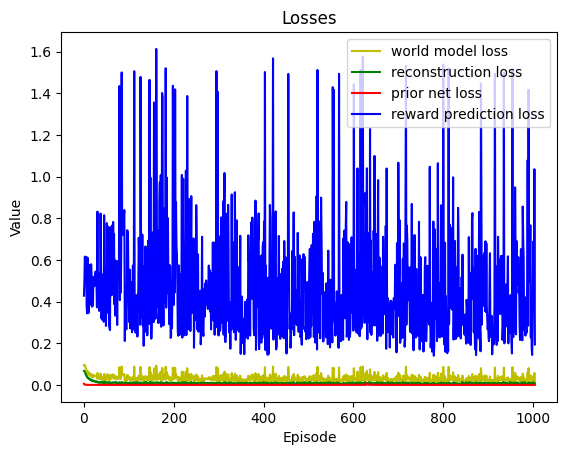

In [2]:
import matplotlib.pyplot as plt
plt.plot(worldModelLosses, linestyle='-', color='y', markersize=5, label="world model loss")
plt.plot(reconstructionLosses, linestyle='-', color='g', markersize=5, label="reconstruction loss")
plt.plot(priorNetLosses, linestyle='-', color='r', markersize=5, label="prior net loss")
plt.plot(rewardPredictionLosses, linestyle='-', color='b', markersize=5, label="reward prediction loss")
plt.legend()
plt.title("Losses")
plt.xlabel("Episode")
plt.ylabel("Value")
plt.show()

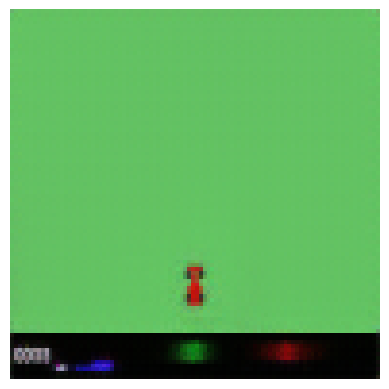

In [5]:
displayImage(np.transpose((dreamer.reconstructObservations(selectedEpisodeObservations, selectedEpisodeActions).cpu())[101], (1, 2, 0)))

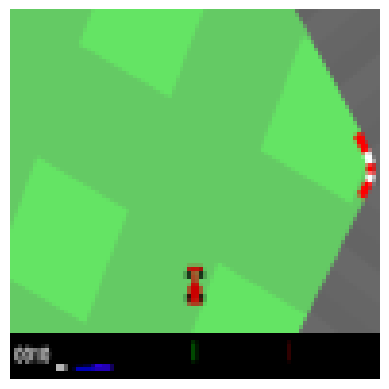

In [6]:
displayImage(np.transpose(selectedEpisodeObservations.cpu()[100], (1, 2, 0)))